# Practica 2

Por Andrés Puente y Fran López-Bleda

## Regresión Logística

En esta practica usaremos los datos de ejemplo proporcionados que representan las notas de los alumnos que se presentaron a un examen de admision a la universidad junto con la informacion sobre si fueron (1) o no (0) admitidos.
El objetivo de la práctica es construir un modelo por regresión logística que estime la probabilidad de que un estudiante sea admitido en esa universidad en base a las notas de sus exámenes.

## INCLUDES

In [1]:
import numpy as np
from pandas.io.parsers import read_csv 
import math as mt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures as pf

### Lectura de los datos de entrada

In [2]:
# Funcion que carga el fichero csv especificado y lo devuelve en un array de numpy
def carga_csv(file_name):
    valores = read_csv(file_name, header = None).values
    # suponemos que siempre trabajaremos con float     
    return valores.astype(float)

In [3]:
datos = carga_csv('ex2data1.csv')

#Notas examenes
results = datos[:, :-1]

#Notas examenes con columna de 1
datosExamenes = np.hstack([np.ones([results.shape[0], 1]), results])
#Indices de aprobados y suspensos
aceptados = datos[:, -1]

m = datosExamenes.shape[0]
n = datosExamenes.shape[1]

theta = np.zeros((1, n))

### Dibujado de los datos

Dibujamos los datos de los examenes para obtener un resultado mas visual

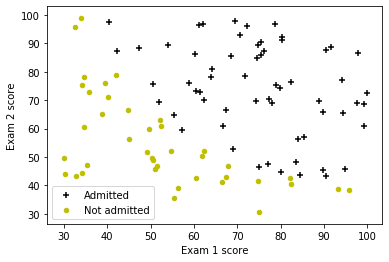

In [4]:
def dibuja_graf(D, R, legend, xLabel, yLabel):
    #np.shape(results)
    pos0 = np.where(D[:,-1] == 0)
    pos1 = np.where(D[:, -1] == 1)
    
    plt.scatter(R[pos1, 0], R[pos1, 1], marker='+', c = 'k', s=30)
    plt.scatter(R[pos0, 0], R[pos0, 1], marker='o', c = 'y', s=20)
    plt.legend(legend)

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
dibuja_graf(datos, results, ['Admitted', 'Not admitted'], 'Exam 1 score', 'Exam 2 score')

In [5]:
# Funcion sigmoide
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

### Funcion Coste
A continuacion implementamos la funcion coste

In [6]:
# Funcion Coste
def cost(theta, x, y):
    sig = sigmoide(np.dot(x, theta.T))
    
    logSig = np.log(sig)
    #logSigT = np.transpose(logSig)
    
    log1 = np.log((1 - sig))
    #log1T = np.transpose(log1)

    c = (-1/m) * (np.dot(y, logSig) + np.dot((1-y),log1))
    return c

def gradiente(theta, x, y):
    return (x.T.dot((sigmoide(x.dot(theta.T))) - y))/m

In [7]:
# Funcion para pintar la recta frontera
def pinta_frontera_recta(X, Y, theta):
    dibuja_graf(datos, results, ['Admitted', 'Not admitted'], 'Exam 1 score', 'Exam 2 score')   
    x1_min, x1_max = X[:, 1].min(), X[:, 1].max()    
    x2_min, x2_max = X[:, 2].min(), X[:, 2].max()        
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),                           
                           np.linspace(x2_min, x2_max))        
    h = sigmoide(np.c_[np.ones((xx1.ravel().shape[0], 1)),
                      xx1.ravel(),
                      xx2.ravel()].dot(theta))
    h = h.reshape(xx1.shape)        
    # el cuarto parámetro es el valor de z cuya frontera se quiere pintar    
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')    

Una vez tenemos las funciones anteriores es momento de dibujar la grafica con la recta de la frontera.

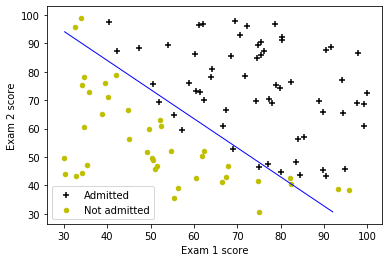

In [8]:
result = opt.fmin_tnc(func=cost , x0=theta , fprime=gradiente , args=(datosExamenes, aceptados)) 
theta_opt = result [0]

pinta_frontera_recta(datosExamenes, aceptados, theta_opt)

A continuacion implementaremos una funcion que calcule el porcentaje de ejemplos de entrenamiento que se clasifican correctamente sobre cada ejemplo de entrenamiento, interpretando si el resultado es >= 0.5 el alumno sera admitido (1) y si es menor no sera admitido(0)

In [9]:
def CalculaPorcentaje(theta_opt, data):
    r = sigmoide(data.dot(theta_opt))
    passed = len(np.where(r >= 0.5))
    fail = len(np.where(r < 0.5))
    total = passed + fail
    return passed / total
    
p = CalculaPorcentaje(theta_opt, datosExamenes)
print("Aprobados: " + str(p * 100) + "%")

Aprobados: 50.0%


# 2. Regresion Logistica Regularizada

### Visualizacion de datos

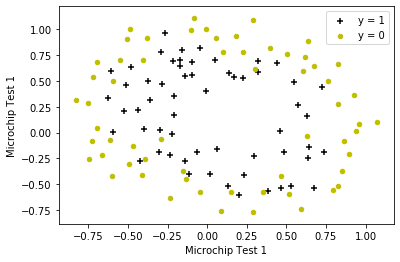

In [10]:
#Datos control calidad
datos2 = carga_csv('ex2data2.csv')

#Notas control calidad
results2 = datos2[:, :-1]
accepted2 = datos2[:, -1]

dibuja_graf(datos2, results2, ['y = 1', 'y = 0'], 'Microchip Test 1', 'Microchip Test 1')

### Mapeo de datos

In [11]:
m = results2.shape[0]
poly = pf(6)
XFitted = poly.fit_transform(results2)
n = XFitted.shape[1]

theta2 = np.zeros(n) #1 fila, 28 columnas
lamb = 1 #lambda

### Funcion coste y gradiente

In [12]:
#Funcion de Coste2
def cost2(O, X, Y, lamb):
    cos = (cost(O, X, Y) + (lamb/2*m)*(O**2).sum())
    return cos

def gradiente2(O, X, Y, lamb):
    grad = (X.T.dot((sigmoide(X.dot(O))) - Y))/m
    sol = (grad + (lamb/m)*0)
    return grad

### Pintar frontera

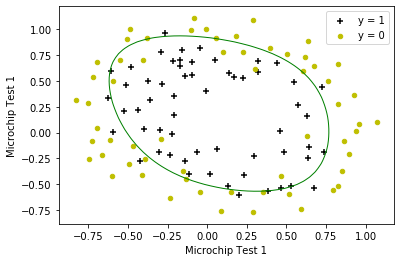

In [13]:
result2 = opt.fmin_tnc(func = cost2, x0 = theta2, fprime=gradiente2, args=(XFitted, accepted2, lamb))
theta_opt2 = result2[0]

def plot_decisionboundary(X, Y, theta, poly):
    plt.figure()
    dibuja_graf(datos2, results2, ['y = 1', 'y = 0'], 'Microchip Test 1', 'Microchip Test 1')
    x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
    x2_min, x2_max = X[:, 2].min(), X[:, 2].max()
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max),
    np.linspace(x2_min, x2_max))
    h = sigmoide(poly.fit_transform(np.c_[xx1.ravel(),
    xx2.ravel()]).dot(theta))
    h = h.reshape(xx1.shape)
    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='g')
    
plot_decisionboundary(XFitted, accepted2, theta_opt2, poly)

### Evaluacion de resultados

In [14]:
def evalua2(O, X):
    res = sigmoide(X.dot(O))
    passed = (res >= 0.5)
    return passed.sum()/res.shape[0]
porcentaje = evalua2(theta_opt2, XFitted)
print("Aprobados: " + str(porcentaje*100) + "%")

Aprobados: 50.847457627118644%
